Retrieving files from Github

In [4]:
from IPython.display import Image

## Installing the hugginface pytorch interface for BERT

### Installing the Hugging Face Pytorch interface for Bert

In [2]:
#@title Installing the hugging face pytorch interface for bert
%pip install -q transformers

Note: you may need to restart the kernel to use updated packages.


## Importing the modules

### Importing the modules

In [7]:
#@title Importing the modules
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

2022-12-29 14:03:38.118446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 14:03:41.356359: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-29 14:03:41.356851: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-29 14:03:41.356879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Specifying CUDA as the device for torch

### Hardware verification and device attribution

In [8]:
#@title Hardware verification and device attribution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Thu Dec 29 14:03:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.65       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   45C    P8    N/A /  N/A |    124MiB /  3072MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading the dataset

In [1]:
import os
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/in_domain_train.tsv --output "./data/in_domain_train.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0   367k      0  0:00:01  0:00:01 --:--:--  367k


In [2]:
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/out_of_domain_dev.tsv --output "./data/out_of_domain_dev.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0  42356      0 --:--:-- --:--:-- --:--:-- 42419


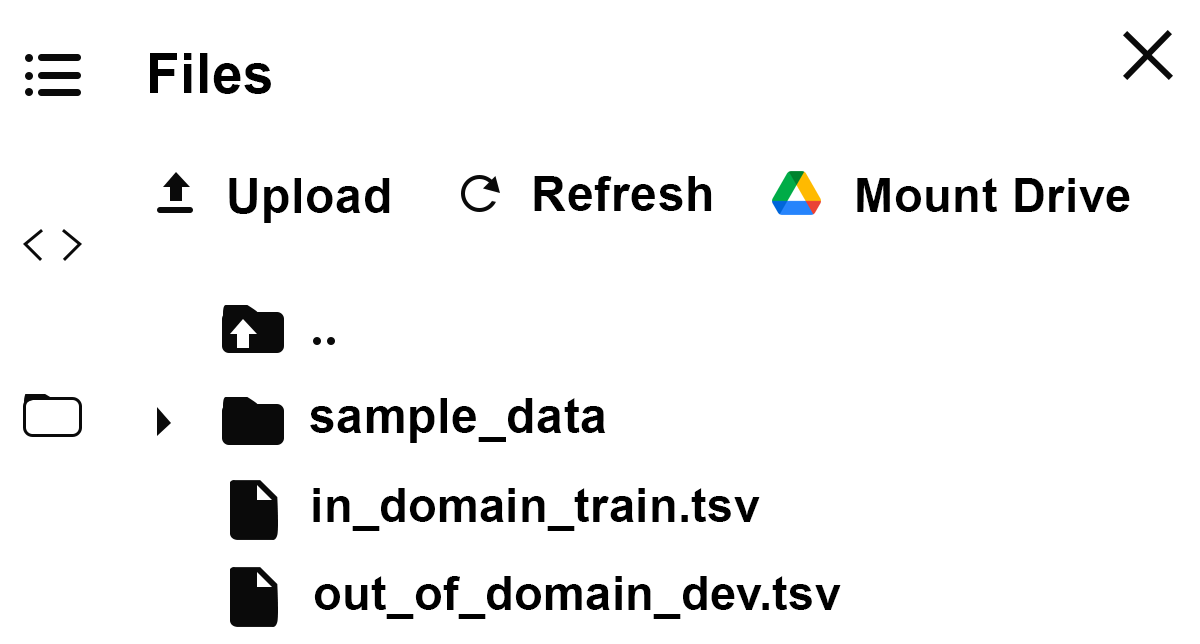

In [5]:
Image('https://github.com/Denis2054/Transformers-for-NLP-2nd-Edition/raw/main/Notebook%20images/03/B17948_03_05.png', width=600) #This is used for rendering images in the notebook

### Loading the dataset

In [9]:
#@title Loading the Dataset
#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("data/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [10]:
df.sample(10)

,sentence_source,label,label_notes,sentence
2980,l-93,1,NaN,i saw the mona lisa .
6522,g_81,1,NaN,who did you think mary saw ?
4381,ks08,0,*,"you did n't leave , left you ?"
1725,r-67,1,NaN,"sally might be pregnant , and i know a girl wh..."
196,cj99,1,NaN,"the more i talk to joe , the less about lingui..."
2456,l-93,1,NaN,suddenly an ugly old man entered the hall .
1114,r-67,0,*,he attributed to a short circuit the fire .
4581,ks08,1,NaN,he can hardly believe that it 's already over .
8301,ad03,1,NaN,did n't the magic work ?
3858,ks08,1,NaN,the students all enjoyed that summer .


## Creating sentences, label lists, and adding BERT tokens

In [11]:
#@ Creating sentence, label list and adding BERT tokens
sentences = df.sentence.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

## Activating the BERT tokenizer

### Activating the BERT tokenizer

In [12]:
#@title Activating the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenize the first sentence:")
print(tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


## Processing the data

### Processing the data

In [13]:
#@title Processing the data
# Set the maximum sequence lenght. The longest sequence in our training set is 47, but we'll leave room on the end anyway
# In the original paper, the authors used a length of 512
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


## Creating attention masks

### Creating attention masks

In [14]:
#@title Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for paddin
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

## Splitting the data into training and validation sets

### Splitting the data into training and validation sets

In [15]:
#@title Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

## Converting all the data into torch tensors

### Converting all the data into torch tensors

In [16]:
#@title Converting all the data into torch tensors
# Torch tensors are the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

## Selecting a batch size and creating an iterator

### Selecting a batch size and creating an iterator

In [17]:
#@title Selecting a Batch Size and Creating and Iterator
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommand a batch size
# of 16 or 32
batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## BERT model configutation

### BERT model configutation

In [18]:
#@title BERT model configuration
# Initializing a BERT bert-base-uncased style configuration
#@title Transformer Installation
try:
    import transformers
except:
    print("Installing transforers")
    !pip -qq install transformers

from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the modek configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## Loading the Huggin Face BERT uncased base model

### Loading the Huggin Face BERT uncased base model

In [19]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = nn.DataParallel(model)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=Tru

## Optimizer grouped parameters

### Optimizer grouped parameters

In [20]:
#@title Optimizer Grouped Parameters
# This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

## The hyperparameters for the training loop

### The hyperparameters for the training loop

In [21]:
#@title The Hyperparameters for the Training Loop 
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = torch.optim.AdamW(optimizer_grouped_parameters,
                lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [22]:
# Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## The training loop

### The training loop

In [23]:
#@title The training loop
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

    # Training

    # Set our model training code (as opposed to evaludation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPUS
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_inputs_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_inputs_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs['loss']
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        scheduler.step()

        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_inputs_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
            # Move logits and labels to CPU
            logits = logits['logits'].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            
            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.48071642441524043


Epoch:  25%|██▌       | 1/4 [12:35<37:46, 755.50s/it]

Validation Accuracy: 0.8200934579439252
Train loss: 0.2631500707203503


Epoch:  50%|█████     | 2/4 [24:23<24:15, 727.66s/it]

Validation Accuracy: 0.8247663551401869
Train loss: 0.12832719133174522


Epoch:  75%|███████▌  | 3/4 [36:46<12:14, 734.44s/it]

Validation Accuracy: 0.8387850467289719
Train loss: 0.06514562739145491


Epoch: 100%|██████████| 4/4 [49:05<00:00, 736.44s/it]

Validation Accuracy: 0.8352803738317757


In [32]:
path2weights='./models/bert_weights.pt'
torch.save(model.state_dict, path2weights)

In [ ]:
# import gc

# model.cpu()
# del model
# gc.collect()
# torch.cuda.empty_cache()

## Training evaluation

### Training evaluation

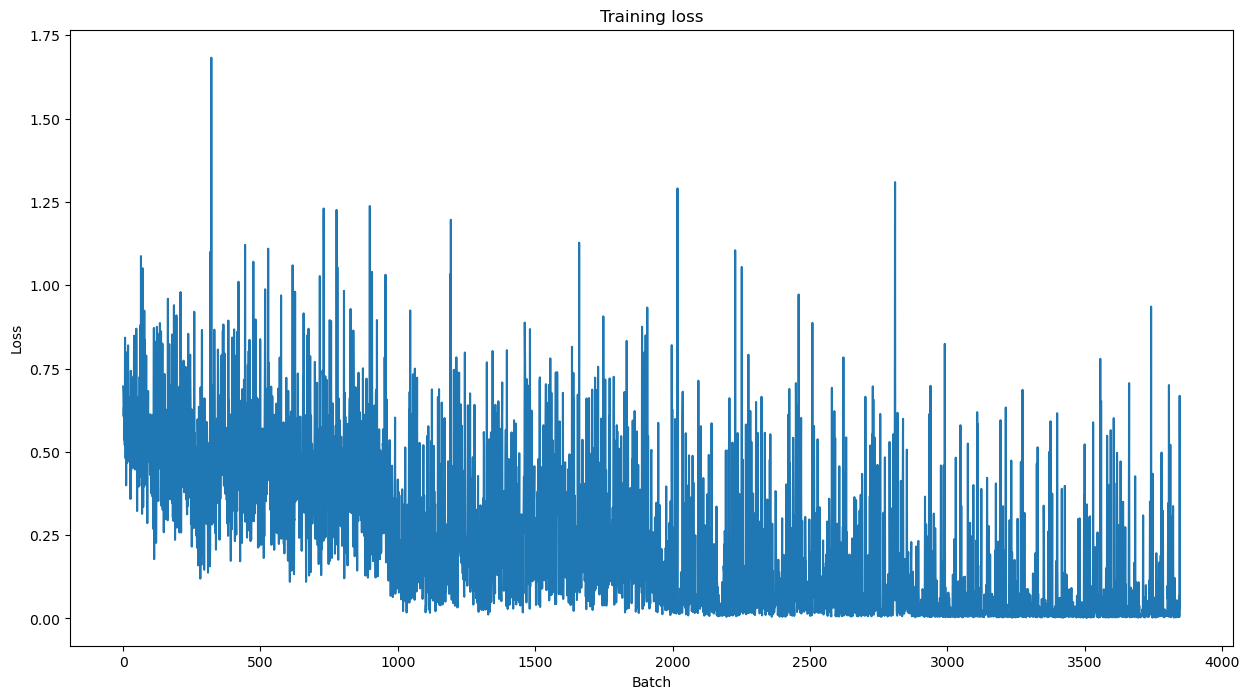

In [24]:
#@title Training Evaluation
plt.figure(figsize=(15, 8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Predicting and evaluating using the holdout dataset

### Predicting and evaluating using the holdout dataset

In [26]:
#@title Predicting and Evaluating Using the Holdout Dataset
df = pd.read_csv("data/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 8

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [27]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

## Evaluating using the Matthews Correlation Coefficient

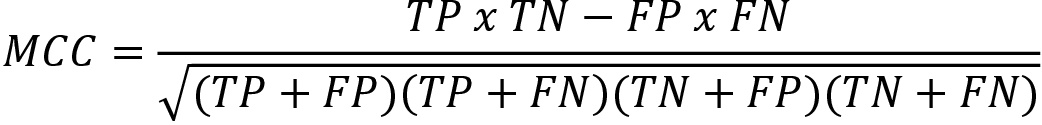

In [25]:
Image('https://github.com/Denis2054/Transformers-for-NLP-2nd-Edition/raw/main/Notebook%20images/03/B17948_03_005.png', width=800) #This is used for rendering images in the notebook

### Evaluating Using Matthew's Correlation Coefficient

In [28]:
#@title Evaluating Using Matthew's Correlation Coefficient
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
    matthews = matthews_corrcoef(true_labels[i], np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)

The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.

## The scores of individual batches

### Score of invidual batches

In [29]:
#@title Score of Individual batches
matthews_set

[0.0,
 0.2182178902359924,
 -0.3779644730092272,
 0.0,
 0.0,
 0.14907119849998599,
 -0.3333333333333333,
 0.0,
 0.0,
 -0.2182178902359924,
 1.0,
 0.5,
 0.7453559924999299,
 0.0,
 -0.2182178902359924,
 -0.3333333333333333,
 -0.4666666666666667,
 0.0,
 0.2581988897471611,
 1.0,
 0.7453559924999299,
 0.6,
 0.7745966692414834,
 0.6546536707079772,
 0.4879500364742666,
 0.6,
 0.6546536707079772,
 0.3779644730092272,
 0.3779644730092272,
 0.0,
 0.0,
 0.0,
 0.7745966692414834,
 0.0,
 0.0,
 0.7745966692414834,
 1.0,
 0.6,
 1.0,
 0.5773502691896258,
 1.0,
 1.0,
 0.5773502691896258,
 0.0,
 0.6546536707079772,
 0.7745966692414834,
 0.0,
 1.0,
 0.5773502691896258,
 0.6,
 1.0,
 1.0,
 1.0,
 0.0,
 0.6546536707079772,
 0.7453559924999299,
 0.6546536707079772,
 -0.14285714285714285,
 1.0,
 0.4879500364742666,
 0.14907119849998599,
 0.7745966692414834,
 -0.14285714285714285,
 1.0,
 0.0]

## Matthews evaluation for the whole dataset

### Matthew's Evaluation on the Whole Dataset

In [30]:
#@title Matthew's Evaluation on the Whole Dataset
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5250884703488709